In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [2]:
tweets = pd.read_excel('POST 2-30 Jun Twitter Data.xlsx')
tweets.head()

,Unnamed: 0,created_at,id_str,user_name,user_id,in_reply_to_status_id_str,in_reply_to_username,like_count,full_text
0,0,2022-06-10 23:59:45+00:00,1535411426688474880,LordFish,11724252,NaN,NaN,0,Where's Amber Heard's dog when you need it!?
1,1,2022-06-10 23:59:22+00:00,1535411331708363008,alicia1110,83481858,1.535098e+18,SupportWitches,0,@SupportWitches @MeghanD19449764 @amandadecade...
2,2,2022-06-10 23:59:17+00:00,1535411309264523008,Rikkamortus13,1490116291729838080,1.535411e+18,Rikkamortus13,1,Another conspiracy is that Amber Heard made up...
3,3,2022-06-10 23:58:33+00:00,1535411125319355904,MarkleSparx,1523057140696506112,1.535411e+18,NielsWetham,2,@NielsWetham @XOlivies @MikalaGrace_ @_emrodri...
4,4,2022-06-10 23:58:28+00:00,1535411103001361920,leebee4life,36448139,NaN,NaN,12,.@TaranaBurke has been doing this work for ove...


In [3]:
df = tweets.filter(['full_text', "created_at"], axis=1)
df2 = df.dropna()
df2.head()

,full_text,created_at
0,Where's Amber Heard's dog when you need it!?,2022-06-10 23:59:45+00:00
1,@SupportWitches @MeghanD19449764 @amandadecade...,2022-06-10 23:59:22+00:00
2,Another conspiracy is that Amber Heard made up...,2022-06-10 23:59:17+00:00
3,@NielsWetham @XOlivies @MikalaGrace_ @_emrodri...,2022-06-10 23:58:33+00:00
4,.@TaranaBurke has been doing this work for ove...,2022-06-10 23:58:28+00:00


# Data cleaning

In [4]:
# Remove non-English words

# remove hashtags 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("#[A-Za-z0-9_]+", " ", str(x)))

# remove mentions
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("@[A-Za-z0-9_]+"," ", str(x)))

# remove links
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub(r"http\S+"," ", str(x)))

# remove "&amp"
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("&amp"," ", str(x)))

# remove punc 
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))

# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())

# remove amber heard and johnny depp
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("amber","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("heard","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("johnny","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("depp","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("ah","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("jd","", str(x)))

# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [5]:
df2.head()

,full_text,created_at,clean_text
0,Where's Amber Heard's dog when you need it!?,2022-06-10 23:59:45+00:00,"[dog, need]"
1,@SupportWitches @MeghanD19449764 @amandadecade...,2022-06-10 23:59:22+00:00,"[see, told, fake, believe]"
2,Another conspiracy is that Amber Heard made up...,2022-06-10 23:59:17+00:00,"[another, conspiracy, made, rape, allegation, ..."
3,@NielsWetham @XOlivies @MikalaGrace_ @_emrodri...,2022-06-10 23:58:33+00:00,"[exist, heres, clip, talking, 30th, bday, stol..."
4,.@TaranaBurke has been doing this work for ove...,2022-06-10 23:58:28+00:00,"[work, decade, need, take, notes, supportive, ..."


In [6]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,created_at,clean_text
0,Where's Amber Heard's dog when you need it!?,2022-06-10 23:59:45+00:00,[dog]
1,@SupportWitches @MeghanD19449764 @amandadecade...,2022-06-10 23:59:22+00:00,[believe]
2,Another conspiracy is that Amber Heard made up...,2022-06-10 23:59:17+00:00,"[conspiracy, rape, allegation, order, money, d..."
3,@NielsWetham @XOlivies @MikalaGrace_ @_emrodri...,2022-06-10 23:58:33+00:00,"[here, clip, bday, story]"
4,.@TaranaBurke has been doing this work for ove...,2022-06-10 23:58:28+00:00,"[work, decade, note, survivor, abuse, work, wo..."


In [7]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


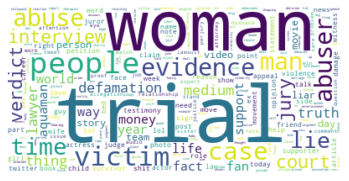

In [8]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

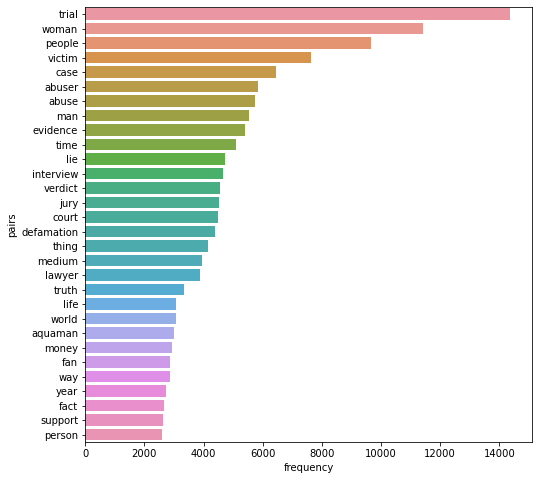

In [9]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [10]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['dog'], ['believe'], ['conspiracy', 'rape', 'allegation', 'order', 'money', 'divorce', 'money', 'abuse', 'allegation']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'dog'), (1, 'believe'), (2, 'abuse'), (3, 'allegation'), (4, 'conspiracy'), (5, 'divorce'), (6, 'money'), (7, 'order'), (8, 'rape'), (9, 'bday'), (10, 'clip'), (11, 'here'), (12, 'story'), (13, 'color'), (14, 'decade'), (15, 'note'), (16, 'survivor'), (17, 'woman'), (18, 'work'), (19, 'year'), (20, 'ad'), (21, 'fragrance'), (22, 'trial'), (23, 'ver'), (24, 'week'), (25, 'abuser'), (26, 'contradict'), (27, 'donation'), (28, 'liar'), (29, 'see'), (30, 'tmz'), (31, 'watch'), (32, 'tv'), (33, 'source'), (34, 'actor'), (35, 'actress'), (36, 'chemistry'), (37, 'dirt'), (38, 'movie'), (39, 'up'), (40, 'officer'), (41, 'police'), (42, 'victim'), (43, 'violence'), (44, 'wife'), (45, 'life'), (46, 'boozebag'), (47, 'call'), (48, 'friend'), (49, 'griffin')]

Total Vocabulary Size: 9592


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [13]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [14]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.3949116371753102
Perplexity Score:  -7.0099624796320565

topic number:  3
Coherence Score:  0.3913414150517886
Perplexity Score:  -7.047944488370596

topic number:  4
Coherence Score:  0.3674589835971579
Perplexity Score:  -7.112734892020309

topic number:  5
Coherence Score:  0.40467210502176226
Perplexity Score:  -7.164208759531395

topic number:  6
Coherence Score:  0.3675840043164993
Perplexity Score:  -7.187716596913036

topic number:  7
Coherence Score:  0.312865862013061
Perplexity Score:  -7.234529170382676

topic number:  8
Coherence Score:  0.32434269984575703
Perplexity Score:  -7.281966470833175

topic number:  9
Coherence Score:  0.33384133677322686
Perplexity Score:  -7.347417085753794

topic number:  10
Coherence Score:  0.29450909352952875
Perplexity Score:  -7.542196344183602

topic number:  11
Coherence Score:  0.28795607152723296
Perplexity Score:  -7.816319883642434

topic number:  12
Coherence Score:  0.307790412387976
Perplexit

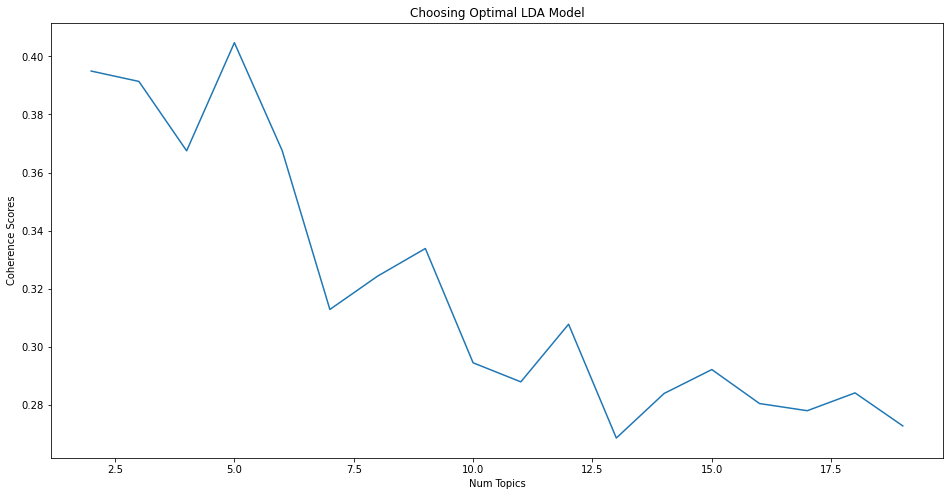

In [15]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [26]:
ntopics_des_name = 5

# We picked 5 because it has the highest coherence score reached before a major drop.

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [27]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.044*"victim" + 0.040*"abuse" + 0.037*"lie" + 0.035*"evidence" + '
  '0.030*"abuser" + 0.019*"truth" + 0.019*"story" + 0.019*"people" + '
  '0.019*"video" + 0.018*"interview"'),
 (1,
  '0.034*"money" + 0.026*"appeal" + 0.025*"aquaman" + 0.024*"movie" + '
  '0.022*"petition" + 0.019*"bed" + 0.015*"sign" + 0.015*"shit" + 0.014*"way" '
  '+ 0.014*"time"'),
 (2,
  '0.087*"woman" + 0.050*"people" + 0.039*"man" + 0.027*"thing" + 0.018*"life" '
  '+ 0.018*"world" + 0.016*"liar" + 0.014*"victim" + 0.014*"supporter" + '
  '0.014*"violence"'),
 (3,
  '0.031*"fact" + 0.030*"trial" + 0.021*"court" + 0.018*"friend" + '
  '0.016*"witness" + 0.015*"case" + 0.014*"wife" + 0.014*"ex" + '
  '0.013*"testimony" + 0.012*"win"'),
 (4,
  '0.091*"trial" + 0.052*"verdict" + 0.044*"defamation" + 0.041*"case" + '
  '0.040*"jury" + 0.037*"lawyer" + 0.021*"team" + 0.020*"medium" + '
  '0.014*"court" + 0.013*"damage"')]


In [28]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [29]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [30]:
df2['Topic'] = topic_num

In [31]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
0,Where's Amber Heard's dog when you need it!?,[dog],"[1, 0, 3, 4, 2]"
1,@SupportWitches @MeghanD19449764 @amandadecade...,[believe],"[2, 0, 1, 3, 4]"
2,Another conspiracy is that Amber Heard made up...,"[conspiracy, rape, allegation, order, money, d...","[1, 0, 2, 3, 4]"
3,@NielsWetham @XOlivies @MikalaGrace_ @_emrodri...,"[here, clip, bday, story]","[0, 1, 3, 4, 2]"
4,.@TaranaBurke has been doing this work for ove...,"[work, decade, note, survivor, abuse, work, wo...","[0, 2, 4, 1, 3]"


### Model Evaluation

In [32]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.1568515351918744
Coherence Score:  0.38359623210221755


## Visualisation

In [33]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.273034  0.180405       1        1  25.418267
0      0.048430  0.186503       2        1  22.442876
4     -0.261036  0.006356       3        1  18.922128
3     -0.219651 -0.007396       4        1  17.041490
1      0.159222 -0.365868       5        1  16.175238, topic_info=           Term          Freq         Total Category  logprob  loglift
17        woman  12296.000000  12296.000000  Default  30.0000  30.0000
22        trial  14488.000000  14488.000000  Default  29.0000  29.0000
72      verdict   5471.000000   5471.000000  Default  28.0000  28.0000
382  defamation   4602.000000   4602.000000  Default  27.0000  27.0000
62       people   9391.000000   9391.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
71         time   1293.047430   4616.742911   Topic5  -4.2404   0.5490
246       other    614.504281    966.704416   Topic5  -4.9843   1.3686
537      career    640.049843   1238.640454   Topic5  -4.9436   1.1615
142         eye    509.243922    825.463659   Topic5  -5.1722   1.3387
64          fan    462.094774   2727.540682   Topic5  -5.2694   0.0463

[248 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.164366    abuse
2         2  0.835611    abuse
25        1  0.344733   abuser
25        2  0.655254   abuser
235       1  0.998270  account
...     ...       ...      ...
19        1  0.341365     year
19        2  0.415541     year
19        4  0.204275     year
19        5  0.038836     year
512       1  0.998797  youtube

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 4, 2])

## Word Count of Topic Keywords

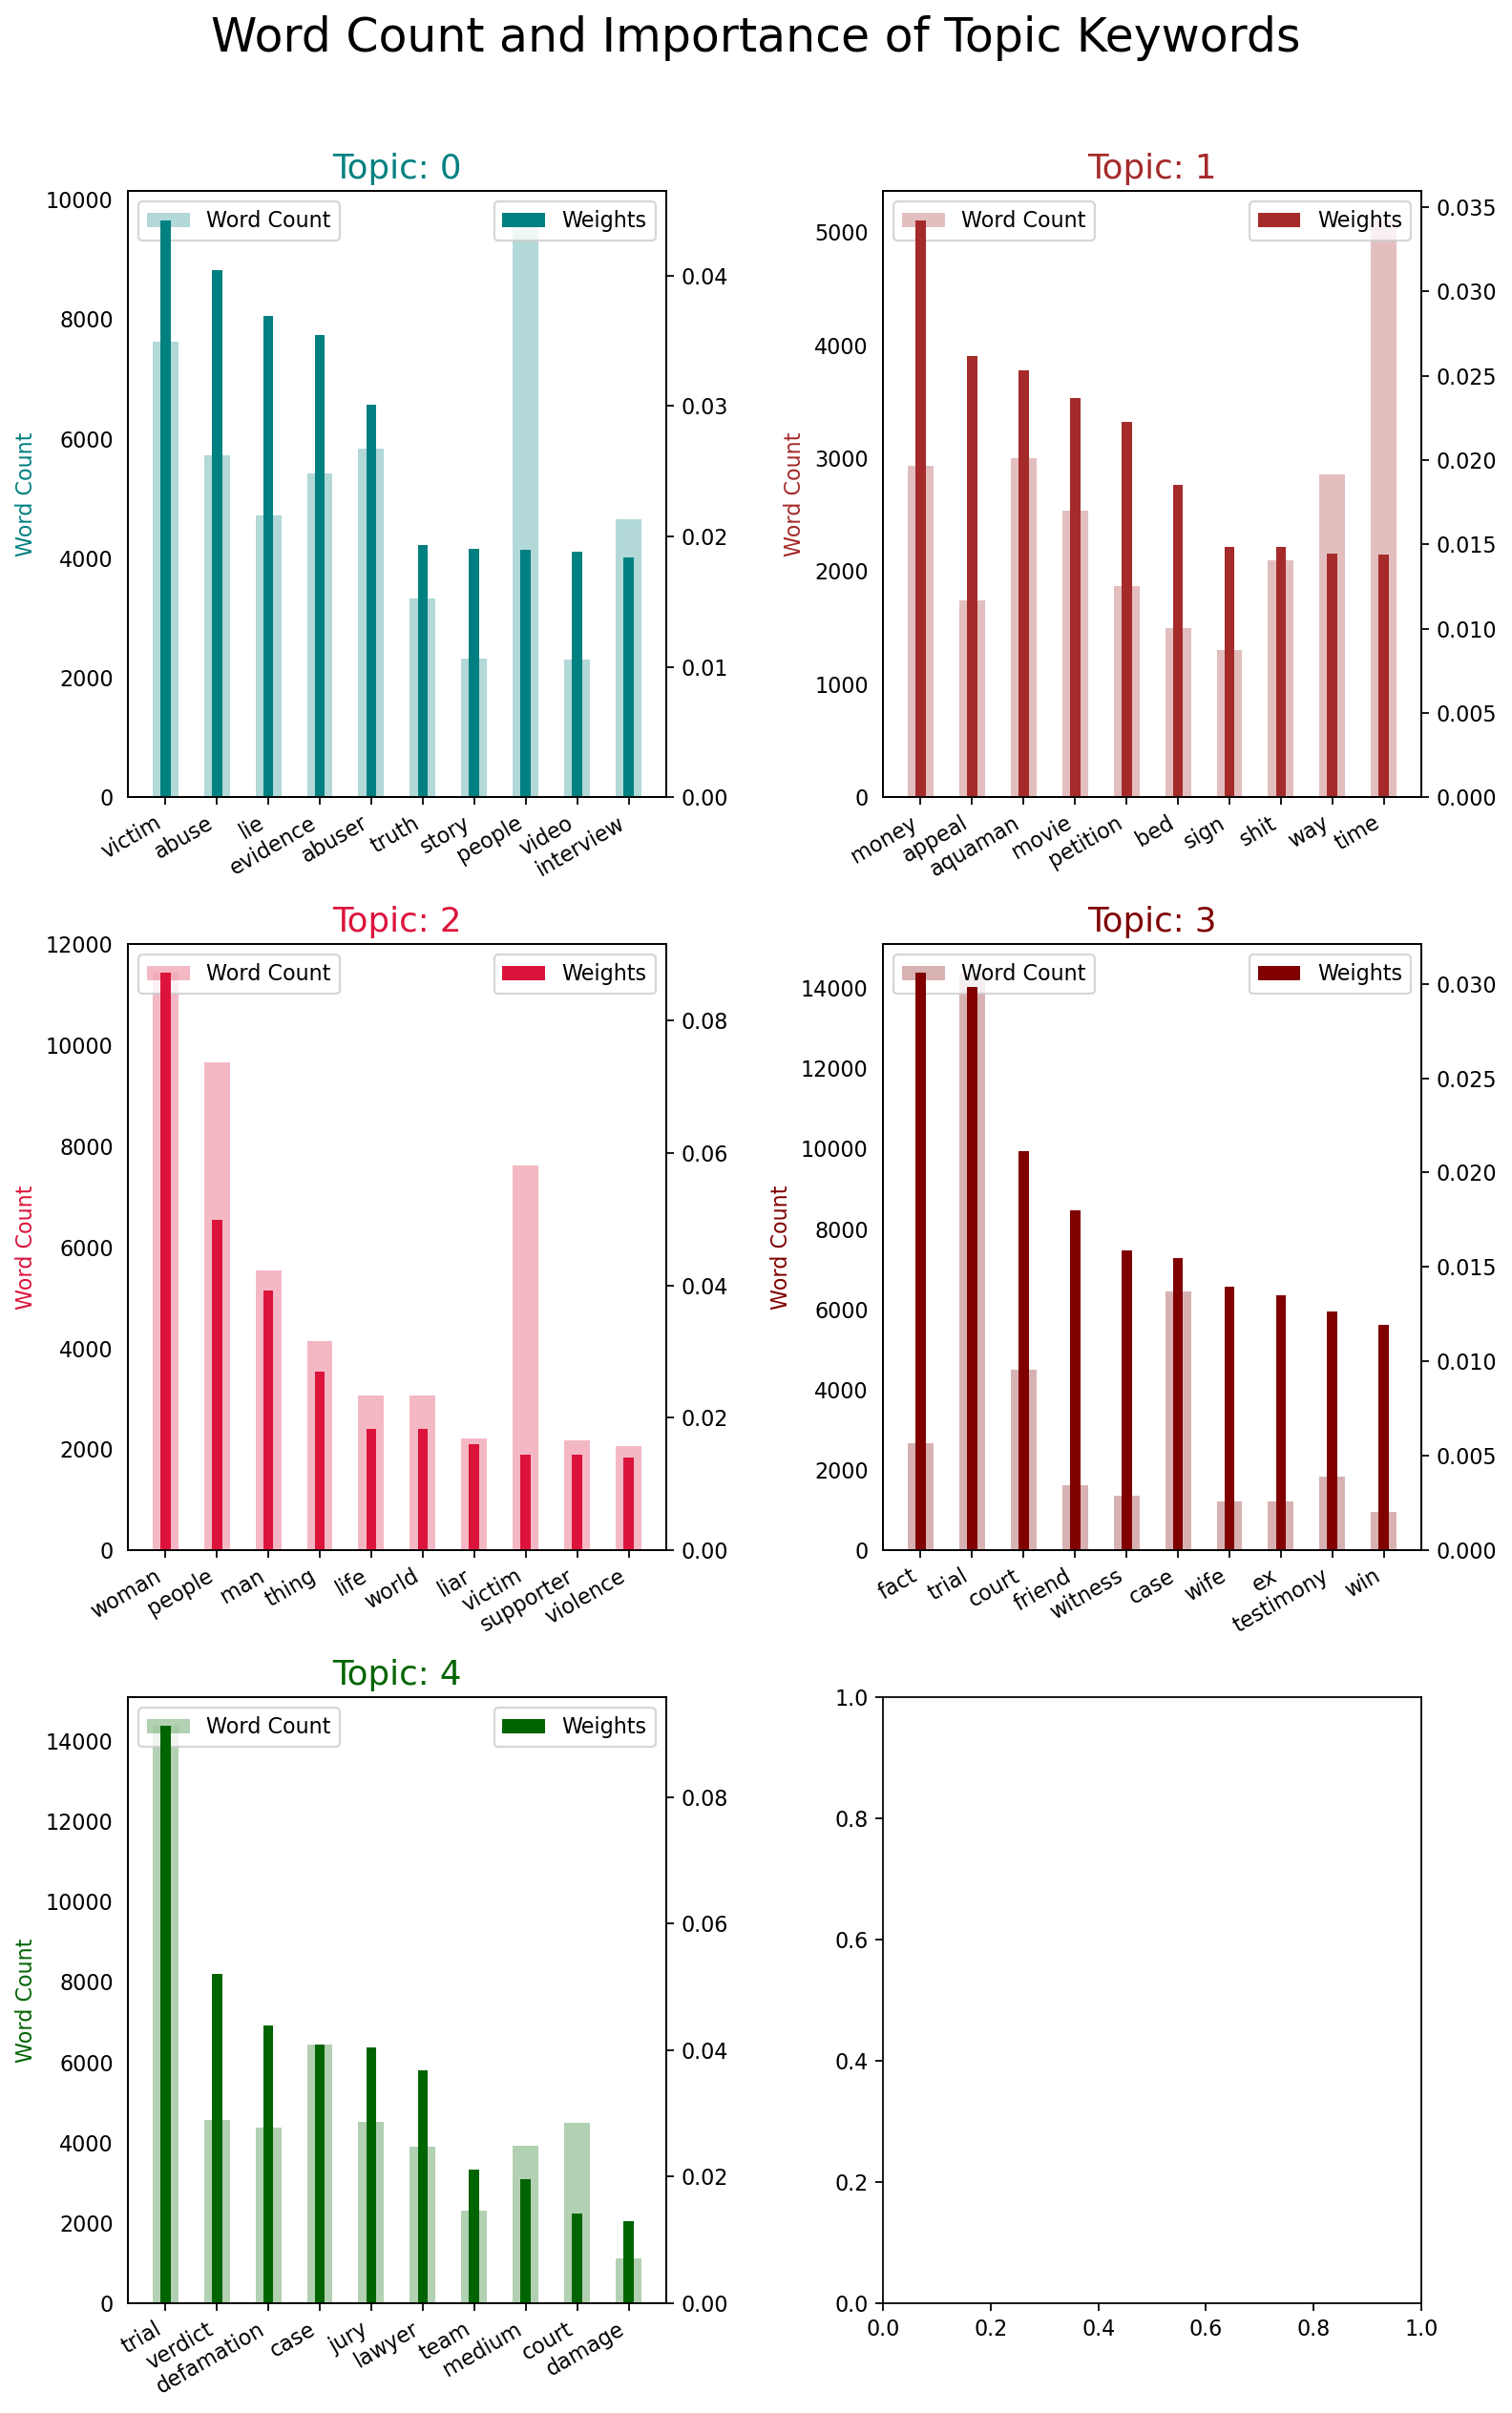

In [36]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
